## Mount gdrive



In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [2]:
cd /gdrive/My Drive/데이터구조

/gdrive/My Drive/데이터구조


In [3]:
ls

01_Python_Basics.ipynb                dataset/
10_Project_Face_Classification.ipynb  ResNet.ipynb




---

## Import Modules

In [0]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms, utils, datasets, models

import random
import os

from skimage import io, transform

import pandas as pd



---

## STEP 1: Loading Dataset

In [5]:
print('STEP 1: LOADING DATASET')

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224), 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
    ])
}

data_dir = './dataset/'
train_dataset = datasets.ImageFolder(data_dir, data_transforms['train'])
valid_dataset = datasets.ImageFolder(data_dir, data_transforms['val'])

num_train = int(len(train_dataset)*0.8)

train_dataset, _ = torch.utils.data.random_split(train_dataset, [num_train, len(train_dataset)-num_train])
_, valid_dataset = torch.utils.data.random_split(valid_dataset, [num_train, len(valid_dataset)-num_train])

STEP 1: LOADING DATASET


In [6]:
print("The number of training images : ", len(train_dataset))
print("The number of validation images : ", len(valid_dataset))

The number of training images :  740
The number of validation images :  186




---

## STEP 2: Making Dataset Iterable (data loader)

In [7]:
print('STEP 2: MAKING DATASET ITERABLE')

data_loaders = {'train': torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True),
                'val': torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=False)
               }


class_names = ['김규상', '김동언', '김성원', '김성준', '김성훈', '김정규', '김정운', '류성환', '박경채', '박진오', '배동건', '변상훈', '원동민', '유영진', '유한결', '윤다솔', '이도훈', '이성철', '이승현', '이정', '이정윤', '이찬', '임지성', '정건모', '정회영', '조성우', '조원호', '조한성', '홍원혁']

STEP 2: MAKING DATASET ITERABLE


In [0]:
def imshow(inp, title=None):
    """ Imshow for Tensor. """
    #print(inp[0])
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

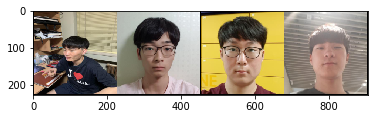

In [9]:
fig = plt.figure()

inputs, classes = next(iter(data_loaders['train']))

out = utils.make_grid(inputs)

imshow(out)



---

## STEP 3: Create Model Class

In [10]:
print('STEP 3: CREATE MODEL CLASS')

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        
        self.conv1 = models.resnet18(pretrained=True, progress=True).conv1
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = models.resnet18(pretrained=True, progress=True).layer1
        self.layer2 = models.resnet18(pretrained=True, progress=True).layer2
        self.layer3 = models.resnet18(pretrained=True, progress=True).layer3
        self.layer4 = models.resnet18(pretrained=True, progress=True).layer4
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, 30)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

STEP 3: CREATE MODEL CLASS




---

## STEP 4: Instantiate Model Class

In [11]:
print('STEP 4: INSTANTIATE MODEL CLASS')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResNet().to(device)
i = 0
for name, param in model.named_parameters():
    #print(i, name) 
    # Fine tune until layer 4[129], layer 3[72]
    if i < 45:
        param.requires_grad = False
        
    i += 1

STEP 4: INSTANTIATE MODEL CLASS


In [12]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.weight
fc.bias




---

## STEP 5 & 6: Instantiate Loss and Optimizer

In [13]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion = nn.CrossEntropyLoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

learning_rate = 0.001
momentum = 0.9

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9)

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS




---

## STEP 7: Train the Model

In [14]:
import time

print('STEP 7: TRAIN THE MODEL')

num_epochs = 20
best_accuracy = 0

for epoch in range(num_epochs):
    start_time = time.time()
    total_loss = 0
    iter = 0
    model.train()
    for i, (images, labels) in enumerate(data_loaders['train']):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Getting Total Loss for Calculat Average Loss of each epochs
        total_loss += loss.item()
        iter += 1
        
        # Updating parameters
        optimizer.step()
        
        if i % 100 == 0 and i != 0:
            print(i,'/', len(data_loaders['train']))
    # Evalutae the time of each epochs.
    running_time = time.time() - start_time
    
    model.eval()
    # Calculate Accuracy         
    correct = 0
    total = 0
    # Iterate through test dataset
    for images, labels in data_loaders['val']:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        # Total correct predictions
        if torch.cuda.is_available():
            correct += (predicted.cpu() == labels.cpu()).sum()
        else:
            correct += (predicted == labels).sum()

        accuracy = 100 * correct.item() / total

    # Print Loss
    print('epoch: {}. Loss: {}. Accuracy: {}. Elapsed: {} sec'.format(epoch, total_loss/iter, accuracy, running_time))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        trained_weight = {'state_dict':model.state_dict()}
print('Best Accuracy : {}'.format(best_accuracy))

STEP 7: TRAIN THE MODEL
100 / 185
epoch: 0. Loss: 2.7562884968680303. Accuracy: 72.04301075268818. Elapsed: 86.95816564559937 sec
100 / 185
epoch: 1. Loss: 1.2816295684994878. Accuracy: 90.86021505376344. Elapsed: 6.5159454345703125 sec
100 / 185
epoch: 2. Loss: 0.6961584033192815. Accuracy: 97.31182795698925. Elapsed: 6.56933069229126 sec
100 / 185
epoch: 3. Loss: 0.404715625015465. Accuracy: 98.9247311827957. Elapsed: 6.54939341545105 sec
100 / 185
epoch: 4. Loss: 0.26758339630590905. Accuracy: 98.9247311827957. Elapsed: 6.722494840621948 sec
100 / 185
epoch: 5. Loss: 0.19998244498227094. Accuracy: 98.38709677419355. Elapsed: 6.699213981628418 sec
100 / 185
epoch: 6. Loss: 0.16844449397679923. Accuracy: 98.38709677419355. Elapsed: 6.5902040004730225 sec
100 / 185
epoch: 7. Loss: 0.13731195056760634. Accuracy: 98.38709677419355. Elapsed: 6.562438011169434 sec
100 / 185
epoch: 8. Loss: 0.13417130612038278. Accuracy: 98.9247311827957. Elapsed: 6.578939199447632 sec
100 / 185
epoch: 9. L



---

## STEP 8: Show Wrong Answers

In [15]:
model.load_state_dict(trained_weight['state_dict'])

model.eval()

# files to be compared
correct = 0
total = 0

softmax = nn.Softmax(dim=1)
# Iterate through test dataset
for images, labels in data_loaders['val']:
  
    images = images.to(device)
    #labels = labels.to(device)

    # Forward pass only to get logits/output
    outputs = model(images)

    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)
    prob, _ = torch.max(softmax(outputs).data, 1)
    fig = plt.figure()

    out = utils.make_grid(images.cpu())
    imshow(out)
    print('Predict : {}'.format([class_names[x] for x in predicted.cpu().tolist()]))
    print('Probability : {}'.format(prob.tolist()))
    print('GT : {}'.format([class_names[x] for x in labels.cpu().tolist()]))

Output hidden; open in https://colab.research.google.com to view.